## Testing, prevalence of active cases, and mortality in Covid

This notebook considers several topics related to Covid mortality
and SARS-CoV-2 virus testing, using data from the [Covid Tracking
project](covidtracking.com).

You can get the data by going to https://covidtracking.com/api, then
downloading the CSV file under "historic state data".  Make sure to
save the data using file name "ctp_daily.csv".  A direct link to the
data is here:

https://covidtracking.com/api/v1/states/daily.csv

We will also use data about the population size for the US states.
This can be obtained from various sources, we will get it directly
from Wikipedia below.

Our main interest here will be to assess whether the reported
testing data for active viral infections, using the PCR testing
platform, are sufficient to explain the variation in Covid-related
mortality.  One of the main reasons to perform viral testing is to
assess the prevalence of infections.  As with any surveillance
activity, it is not necessary to detect all cases to estimate the
prevalence.  It is sufficient to detect a fraction of the cases, and
generalize to the full population.  Unfortunately, SARS-CoV-2
testing has been performed extremely haphazardly -- a very
non-representative subpopulation has been tested.  Therefore, we
will not actually be aiming literally for the prevalence here
(e.g. cases per thousand population).  Instead, we take the point of
view that the question of whether enough testing has been done
can largely be settled by assessing to what extent testing results
predict mortality, which is the main hard endpoint for Covid.

We note that there are other possible uses of testing such as for
use in contact tracing, identifying emerging disease hotspots, and
assessing cumulative prevalence of past exposure to the virus.
These are distinct goals from prevalence estimation, and likely
would require much more extensive and more systematic testing. These
goals are not considered further here.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

In [2]:
# Below we get state population data from Wikipedia.  We only download
# the file one time and store it locally as 'states.csv'.
if not os.path.exists("states.csv"):

    # Map full state names to postal codes
    dm = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
        "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC",
        "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN",
        "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
        "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO",
        "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
        "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
        "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Puerto Rico": "PR", "Rhode Island": "RI",
        "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
        "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI",
        "Wyoming": "WY"}

    ta = pd.read_html("https://simple.m.wikipedia.org/wiki/List_of_U.S._states_by_population",
                      attrs={"class": "wikitable sortable"})
    ta = ta[0].iloc[:, 2:4]
    ta["SA"] = [dm.get(x, "") for x in ta.State]
    ta = ta.loc[ta.SA != "", :]
    ta.columns = ["state", "pop", "SA"]
    ta = ta.loc[:, ["state", "SA", "pop"]]
    ta = ta.sort_values(by="state")
    ta.to_csv("states.csv", index=None)

Next we load and merge the Covid data and the state population data.

In [3]:
df = pd.read_csv("ctp_daily.csv")
dp = pd.read_csv("states.csv")
dp = dp.drop("state", axis=1)
df = pd.merge(df, dp, left_on="state", right_on="SA", how="left")
df["pdate"] = pd.to_datetime(df.date, format="%Y%m%d")
dx = df.loc[:, ["date", "pdate", "state", "positive", "negative", "death", "pop"]].dropna()
dx = dx.sort_values(by=["state", "pdate"])

The data as provided are cumulative, so we difference it to get the
daily values.

In [4]:
dx["ddeath"] = dx.groupby("state")["death"].diff()
dx["dpositive"] = dx.groupby("state")["positive"].diff()
dx["dnegative"] = dx.groupby("state")["negative"].diff()
dx = dx.dropna()

## Relationship between testing results and mortality.

The Covid Tracking project reports cumulative daily counts of
Covid-related deaths for each US state, and also reports the
cumulative numbers of positive and negative Covid tests.  The tests
reported are primarily PCR tests that assess for viral RNA, which
should indicate an active or recently cleared SARS-CoV-2 infection.
The number of positive tests and the number of negative tests are
reported for each US state and for each day.

There is a lot of discussion and debate about the characteristics of
PCR testing for SARS-CoV-2.  One useful reference for this topic is:

https://asm.org/Articles/2020/April/False-Negatives-and-Reinfections-the-Challenges-of

To summarize:

* It is currently unknown for how long after infection, symptom
onset, or recovery a person may continue to have positive PCR test
values.  It is likely that this duration could be from 1 to 4 weeks
in most cases.

* The PCR test is quite sensitive, approaching 100% in lab
conditions, but false negatives can result from flawed sample
collection.

* The PCR test is quite specific in the narrow sense -- if it
detects viral RNA, then viral RNA was probably present.  However it
is possible that PCR may detect residual non-pathogenic RNA remnants
from a cleared infection.

* Viral load is highest early in the course of the infection,
including during the pre-symptomatic or asymptomatic period. People
with severe Covid complications that persist several weeks after
symptom onset may have minimal viral load by that time, and are
primarily impacted by the after-effects of their immune response to
the virus.

* It is currently unknown what fraction of the many people with
minimal or no symptoms following SARS-CoV-2 exposure will receive a
test and then test positive via PCR.

* Antibody testing detects past infection, which in most cases will
have resolved to the point where a concurrent PCR test would be
negative.  We only have basic summaries of the antibody testing that
has been done to date.  Reportedly, a few states have counted
antibody tests among the PCR tests.  We do not attempt to account
for that here.

We should also keep in mind that each US state follows different
practices for testing and reporting.  For mortality data, there may
be differences in which deaths are deemed to be Covid-associated.
There are likely to be substantial undercounts, for example some
states during some periods of time only reported deaths in
hospitals.  But there could be some overcounting as well, e.g. a
person with multiple severe illnesses, including Covid, may not have
died primarily due to Covid.

For the testing data, each state has its own policies about who can
get tested.  Early in the epidemic testing was severely constrained
by the availability of test kits.  Not all states have consistently
reported negative test results, but reporting of test positives is
presumably somewhat more consistent.  The sample of tested people is
not representative of the general population, and is likely a
heterogeneous mix of health-care workers and people with Covid symptoms
It is certainly enriched for cases.

Below are plots of the daily death counts for New York and for Michigan:

/nfs/kshedden/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


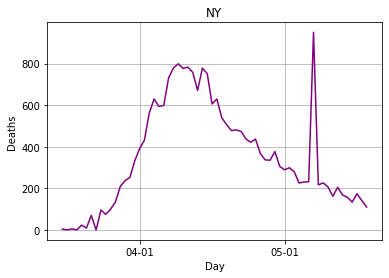

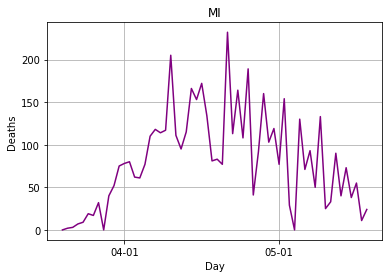

In [5]:
fmt = mdates.DateFormatter("%m-%d")
months = mdates.MonthLocator()

for st in "NY", "MI":
    da = dx.loc[dx.state==st, :]
    plt.clf()
    plt.grid(True)
    plt.plot(da.pdate.values, da.ddeath.values, '-', color='purple')
    plt.title(st)
    plt.xlabel("Day")
    plt.ylabel("Deaths")
    plt.gca().xaxis.set_major_formatter(fmt)
    plt.gca().xaxis.set_major_locator(months)
    plt.show()

Below are plots of the daily number of positive tests for New York
and for Michigan:

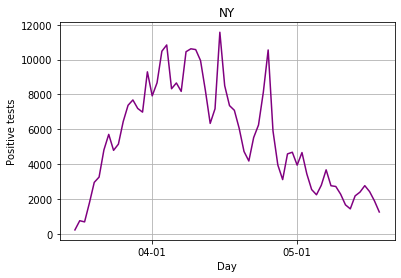

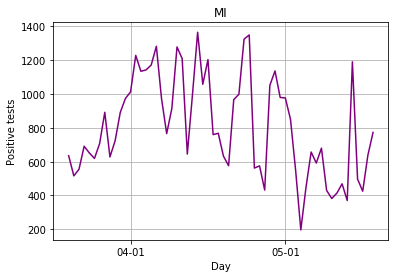

In [6]:
for st in "NY", "MI":
    da = dx.loc[dx.state==st, :]
    plt.clf()
    plt.grid(True)
    plt.plot(da.pdate.values, da.dpositive.values, '-', color='purple')
    plt.title(st)
    plt.xlabel("Day")
    plt.ylabel("Positive tests")
    plt.gca().xaxis.set_major_formatter(fmt)
    plt.gca().xaxis.set_major_locator(months)
    plt.show()

Our main analysis will use a regression approach to relate
SARS-CoV-2 testing results to Covid mortality.  As noted above, the
motivation for this analysis is that the people who test positive
can be viewed in some way as representing the prevalence of active
infections (with many caveats, to be discussed below).  Thus,
understanding the statistical relationship between testing results
and Covid mortality can be informative about the relationship
between exposure and mortality.

Since people who die from Covid typically were infected several
weeks prior to their death, we will create counts of testing
positives and negatives in several windows of width one week,
lagging behind the mortality count.

In [7]:
# Sum x from d2 days back in time to d1 days back in time, inclusive of
# both endpoints.  d2 must be greater than d1.
def wsum(x, d1, d2):
    w = np.ones(d2 + 1)
    if d1 > 0:
        w[-d1:] = 0
    y = np.zeros_like(x)
    y[d2:] = np.convolve(x.values, w[::-1], mode='valid')
    return y

for j in range(4):
    dx["cumpos%d" % j] = dx.groupby("state").dpositive.transform(lambda x: wsum(x, 7*j, 7*j+6))
    dx["cumneg%d" % j] = dx.groupby("state").dnegative.transform(lambda x: wsum(x, 7*j, 7*j+6))
    dx["logcumpos%d" % j] = np.log(dx["cumpos%d" % j] + 1)
    dx["logcumneg%d" % j] = np.log(dx["cumneg%d" % j] + 1)

/nfs/kshedden/python3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Below we will use regression analysis to try to understand how
SARS-CoV-2 testing results relate to Covid mortality.  A reasonable
hypothesis would be that a greater number of positive test results
predicts greater mortality, at a 1-4 week lag.  More specifically,
all else held equal, comparing two places/times where the Covid
prevalence differs by a factor of two over the past month, we expect
there to be a factor of two difference in Covid mortality today.

Another reasonable hypothesis would be that the ratio of positive to
negative test results, rather than the absolute number of positive
test results, could be a stronger predictor of mortality.  This is
based on the logic that taking this ratio corrects for the fact that
states may increase their testing when a big surge in cases is
expected.

There are several other factors that we should consider and account
for if possible:

* The virus arrived in different states at different times, e.g. it
arrived in New York before it arrived in South Dakota.

* States vary greatly in terms of population size.  It is reasonable
to expect death counts to scale with population size.

* Transmission rates may vary by state, e.g. due to population
density.

* The seasons were changing just as the epidemic in the US reached
its peak.  Spring weather may reduce transmission rates.

* The infection/fatality ratio (IFR) may vary by state due to
demographic characteristics of the population and prevalence of
comorbidities.

To account for differences in the time when the disease arrived in
each state, we identify the date of the first Covid death, then
include only the data starting 10 days after that date.

In [8]:
def firstdeath(x):
    if (x.death == 0).all():
        return np.inf
    ii = np.flatnonzero(x.death > 0)[0]
    return x.pdate.iloc[ii]

xx = dx.groupby("state").apply(firstdeath)
xx.name = "firstdeath"
dx = pd.merge(dx, xx, left_on="state", right_index=True)

dx["rdate"] = (dx.pdate - dx.firstdeath).dt.days
dx = dx.loc[dx.rdate >= 10, :]

Below is an initial regression analysis looking at mortality counts
per state/day as an outcome that is predicted by testing results.
We also include state level fixed effects to control for the
possibility of different infection/fatality ratios among the states.
The model is fit using a Poisson generalized estimating equations
(GEE) approach, clustering the data by state.  This allows data
values in the same state to be correlated, e.g. through a serial
correlation with respect to time.

In [9]:
fml = "ddeath ~ 0 + C(state) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m1 = sm.GEE.from_formula(fml, groups="state", data=dx, family=sm.families.Poisson())
r1 = m1.fit(scale="X2")
print(r1.summary())

                               GEE Regression Results                              
Dep. Variable:                      ddeath   No. Observations:                 2509
Model:                                 GEE   No. clusters:                       52
Method:                        Generalized   Min. cluster size:                  26
                      Estimating Equations   Max. cluster size:                  69
Family:                            Poisson   Mean cluster size:                48.2
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 01 Jun 2020   Scale:                          10.719
Covariance type:                    robust   Time:                         14:25:43
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
C(state)[AK]    -3.9572      0.559     -7.084      0.000      -5.052      -2.862
C

A perfect 1-1 relationship between testing and mortality would
manifest as a perfect linear relationship between the log number of
cases and the log number of positive tests.  In this case, we would
expect the regression coefficients for the log number of positive
tests to be equal to 1 (assuming that cases and mortality are 1-1 at
some lag).  As we see above, the coefficient for the log number of
positive tests in the week immediately preceding the day of the mortality
count is around 0.62, and the coefficients for the two weeks prior
to that were 0.16 and 0.04 respectively.  Note that these
coefficients sum to around 0.8 -- if the positive tests in two
states/4 week time periods differ by a factor of two, the state/time
with more positive tests will have around 80% more deaths.  The fact
that these effects are spread across several lagged terms may
reflect variation in the timing of death relative to infection.

Note also that there is a statistically significant inverse
relationship between the log number of negative tests in the prior
weeks and mortality.  However the coefficients of the negative test
result variables do not sum to a value close to 1.  This would argue
against using the ratio of the number of positive to negative tests
as a predictor of mortality.

As noted above, only a fraction of the people who have been exposed
to SARS-CoV-2 virus are tested during the period of time when they
would have a positive PCR test.  There is an unknown scaling factor
called the "ascertainment ratio" between the number of exposed
people and the number of people who are tested and found to have an
active infection.  The results here do not tell us anything about
this ratio.  Instead, the results here tell us that the testing in
the U.S., with all its flaws, is sufficiently comprehensive and
representative to capture around 80% of Covid mortality.  More
representative testing, which may or may not involve a greater
volume of testing, would potentially capture 100% of Covid
mortality.

## State effects and variation in the IFR

The analysis above uses state-level fixed effects to account
for state-to-state differences from various sources.  From a
statistical perspective, this is one of several ways to address
this issue.  Including large numbers of fixed effects in any
regression model can raise concerns about there being sufficient
data to estimate these parameters.  This is classically known
as the "Neyman-Scott" problem.  Alternatives to fixed effects
include mutilevel analysis, shrunken fixed effects, and marginal
analysis that allow for covariances within states (which we have
done here via GEE).

If we believe that the positive and negative testing data are
sufficiently informative about the prevalence of the disease at each
state/time, then the state fixed effects in the above model might
reflect state-to-state differences in the infection/fatality ratio.
The analysis below shows that these state effects have a range of
around 4.4 on the log scale, with a standard deviation of 0.82.
Since exp(0.82) ~ 2.27, this might suggest that most states have IFR
values that are within a factor of around 2.5 of the mean
state-level IFR.

Variation on the order of 2 or more suggests major contributions
of state-level factors to Covid mortality.  Note in particular
that Michigan, New York, Pennsylvania and other hard-hit states
have large fixed effects, suggesting that they either have lower
case ascertainment, or higher infection fatality rates.

In [10]:
# Extract the state fixed effects
pa = r1.params
st = [y for x, y in zip(pa.index, pa.values) if "state" in x]
st = np.asarray(st)

print("Range of state effects:")
print(st.min(), st.max())

print("Unadjusted SD of state effects:")
print(st.std())

Range of state effects:
-5.368611589075238 -0.99837848022408
Unadjusted SD of state effects:
0.8253747958120818


The state fixed effects discussed above are estimates, not exact
values.  The estimation errors in these quantities inflate their
variance when estimated naively as in the preceding cell.  This can
be addressed as shown below.  However the results show that the
bias is not great in this case, and the relationship between testing
and mortality may commonly differ from state-to-state by factors on
the order of 2-3.

In [11]:
ii = [i for i, x in enumerate(pa.index) if "state" in x]
c = r1.cov_params().iloc[ii, ii]

# This is a method of moments adjustment to remove the extra variance
# due to parameter estimation.  We do not provide all the details
# here.
p = len(st)
oo = np.ones(p)
qm = np.eye(p) - np.outer(oo, oo) / p # Centering matrix
bias = np.trace(np.dot(qm, np.dot(c, qm)))
v = np.dot(st, np.dot(qm, st)) - bias
v /= p

print("Adjusted variance and SD of state effects:")
print("variance=%f, SD=%f\n" % (v, np.sqrt(v)))

Adjusted variance and SD of state effects:
variance=0.668018, SD=0.817324



## Alternative models and confounding

As with any observational data set, there are many opportunities for
confounding to mislead us.  One such possibility is that all the US
states have progressed through the Covid epidemic over roughly the
same time period, and during this time the weather became much
warmer in most of the US.  In fact, weather is just one possible
confounder indexed by time (e.g. standards of care have evolved and
may have impacted the IFR).  To address this possibility, we fit
models in which calendar date, or date relative to the state's first
Covid death are included as controls.  We find that the coefficients
for the positive and negative testing results are relatively
invariant to inclusion of these terms.  Also, based on a score test,
the inclusion of rdate (the number of days within a state since that
state's first recorded Covid death) is not statistically
significant.

In [12]:
fml = "ddeath ~ 0 + C(state) + bs(rdate, 5) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
m2 = sm.GEE.from_formula(fml, groups="state", data=dx, family=sm.families.Poisson())
r2 = m2.fit(scale="X2")
print(r2.summary())
print("Score test for model 2 relative to model 1:")
print(m2.compare_score_test(r1))

                               GEE Regression Results                              
Dep. Variable:                      ddeath   No. Observations:                 2509
Model:                                 GEE   No. clusters:                       52
Method:                        Generalized   Min. cluster size:                  26
                      Estimating Equations   Max. cluster size:                  69
Family:                            Poisson   Mean cluster size:                48.2
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 01 Jun 2020   Scale:                          10.553
Covariance type:                    robust   Time:                         14:25:44
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(state)[AK]       -3.6364      0.596     -6.101      0.000      -4.805     

As noted above, it makes sense to model death relative to population
size.  Since the Poisson regression that we will be using has a log
link function, to properly account for population effects we should
use the log of the total population as an offset, or as a covariate.
Note however that Covid has largely arisen in geographically-limited
clusters that are smaller than an entire state.  For this reason,
the state population may not be the perfect offset to use for this
purpose.  Ideally, we would have mortality and testing data at a
finer geographical scale, for example by county.  But that data is
not available now.

In [13]:
dx["lpop"] = np.log(dx["pop"])

Since population size is a state-level variable and we already have
included state fixed effects in the model, a main effect of
population size has already been accounted for in the models above.
However we can take the question of population scaling a bit further
by considering interactions between population size and the positive
test counts.  As shown below however, these coefficients are not
statistically significant based on the score test.

In [14]:
dx["lpop_cen"] = dx.lpop - dx.lpop.mean()
fml = "ddeath ~ 0 + C(state) + bs(rdate, 5) + "
fml += " + ".join(["lpop_cen*logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["lpop_cen*logcumneg%d" % j for j in range(4)])
m3 = sm.GEE.from_formula(fml, groups="state", data=dx, family=sm.families.Poisson())
r3 = m3.fit(scale="X2")
print("Score test for model 3 relative to model 2:")
print(m3.compare_score_test(r2))

Score test for model 3 relative to model 2:
{'statistic': 3.144053283840204, 'df': 9, 'p-value': 0.9583086039808422}


## Dispersion relative to the mean and the scale parameter

Above we focused on the mean structure of the model, which is
reflected in the slope parameters for the covariates.  These
parameters determine the expected mortality count for any given
state/date pair.  We should also consider to what extent the data
are scattered with respect to this mean.  This is captured through
the scale parameter of the quasi-Poisson regression.

In [15]:
print(r1.scale)
print(r2.scale)
print(r3.scale)

10.719056894065115
10.552970538459268
10.409096549371016


In an ideal Poisson regression, the scale parameter is equal to 1,
meaning that the conditional variance is equal to the conditional
mean.  Here we are seeing that the conditional variance is around 10
times greater than the conditional mean.

The conventional approach for estimating the scale parameter is
analogous to the sample variance, using the "Pearson residuals".

In [16]:
resid = r2.resid_pearson
print(np.var(resid))

# This is how the Pearson residuals are constructed:
f = np.exp(np.dot(m2.exog, r2.params))
resid0 = (m2.endog - f) / np.sqrt(f)

assert(np.all(np.abs(resid - resid0) < 1e-10))

10.278036657228618


As we saw above, there are some large outliers in the mortality
data, and we have good reason to believe that these outliers do not
reflect actual daily death counts.  Therefore it might make sense to
use an alternative approach to calculating the scale parameter that
is not too strongly influenced by a few outlying values.  One way to
do this is using "Huber's proposal 2" estimate of the scale.  This
estimator solves a modified ("clipped") version of the moment-based
estimating equation solved by the usual sample variance.

Huber's scale estimate is around 4.15, indicating how the usual
scale estimate is inflated by a few large outliers.  Thus, we see
that the conditional variance in the number of Covid deaths is
around 4-10 times greater than the conditional mean number of Covid
deaths, depending on how we estimate the scale parameter.

In [17]:
def g(s, x=resid):
    c = 1.345
    return np.sum(np.clip(x / s, -c, c)**2)

# This is around 0.84, slightly less than 1 due
# to clipping.
gam = g(1, np.random.normal(size=50000)) / 50000

# This is the equation that we wish to solve to estimate
# the scale parameter s.
def h(s):
    return g(s).sum() - gam*(m2.nobs - r2.params.size)

# Left bracket
s0 = r2.scale
while h(s0) < 0:
    s0 /= 2

# Right bracket
s1 = r2.scale
while h(s1) > 0:
    s1 *= 2

from scipy.optimize import root_scalar

scale_huber = root_scalar(h, bracket=[s0, s1]).root**2

In a perfect Poisson situation, the variance would be equal to the
mean.  This perfect Poisson behavior would arise if we had
independence and homogeneity -- independence meaning that any two
people living in the same state on the same day die of Covid
independently of each other, and homogeneity meaning that any two
people living in the same state on the same day have the same
probability of dying of Covid.  The independence condition is likely
to hold, but the homogeneity condition is not.  Our data are not
stratified by known risk factors, sex and age being most
well-established.  Also, there are complex artifacts in the way
death reports are distributed over the days of the week.  Pooling
data with different event probabilities will give us a scale
parameter greater than 1, as is seen here.

Although we don't have access to the stratified data that we would
need to characterize these sources of dispersion, we can do some
sensitivity analyses to see to what extent age and sex effects might
inflate the scale parameter.

The following function implements a form of sensitivity analysis in
which we attempt to identify population structures that are
consistent with the findings we reached above with the Covid
tracking project data.  Our goal here is to get a better sense for
how much heterogeneity would be needed to attain a scale parameter
around 10, while respecting the marginal mean structure estimated
above.  We can do this, in a very hypothetical way, by imagining
that our population consists of two groups with different risks.  If
we specify the prevalences of these two groups, and the risk ratio
between them, and force the marginal mean to agree with what we
found above, we can calculate the scale parameter.

This idea is implemented in the function below.  The parameter
'high_risk' is a hypothetical risk ratio between a high risk group
and a low risk group.  The parameter 'pr_high' is the hypothetical
proportion of the population in the high risk group.

In [18]:
def scale_2group(high_risk, pr_high):
    f = np.r_[1, high_risk]
    pr = np.r_[1 - pr_high, pr_high]
    f /= np.dot(f, pr)
    ex = r1.fittedvalues
    exq = [fx*ex for fx in f]
    mcv = sum([p*b for (p, b) in zip(pr, exq)])
    vcm = sum([p*(b-ex)**2 for (p, b) in zip(pr, exq)])
    tv = mcv + vcm
    return (tv/ex).mean()

If we calculate the hypothetical scale parameter for an imaginary
population in which 5% of the population is 4 times more likely to
die than the others, we get a scale parameter of around 11, which is
close to our observed scale parameter.  Of course the real world
does not consist of two homogeneous groups, but this may not be as
far as one would imagine from reality.  For example, including a
third group with very low risk would not change anything.
Consistent with observed data, we can suppose that the risk of dying
for people under 40 is negligible.

Below we show two hypothetical 2-group scenarios that would explain
the scale parameters estimated in the conventional way, and
robustly.  In the first case, we posit that 5% of the population has
a 3.8 times greater risk of death than the others.  In the second
case, we posit that 2% of the population has a 3.3 times greater
risk of death than the others.

In [19]:
print(scale_2group(3.8, 0.05))
print(scale_2group(3.3, 0.02))

10.494514484697184
4.139938674770221


As another illustration, if half the population (i.e. males) has a 2
times greater risk of death than the others, then we get a scale
parameter that is in-range with our estimated values.

In [20]:
print(scale_2group(2.0, 0.5))

4.681546432841761
